<a href="https://colab.research.google.com/github/pyratlib/pyrat/blob/main/PyRAT_Neural_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyRAT example

This notebook has examples of using the library to correlate electrophysiological data with the behavioral data. The data is stored on Zenodo (https://doi.org/10.5281/zenodo.5865893) and the spikes data used is from Fujisawa et al., 2008, freely available online (http://dx.doi.org/10.6080/K01V5BWK).

Sections <a name="manipulations"></a>:

1.   [Electophysiology Signal](#electophysiology)
2.   [Spikes](#spikes)


For more details: https://github.com/pyratlib/pyrat

In [1]:
#@title Installing PyRAT and downloading data.
!pip install pyratlib
!pip install wget
!pip install unrar
!git clone 
!wget https://zenodo.org/record/5883277/files/PyRAT_dataset.rar?download=1
!unrar x "/content/PyRAT_dataset.rar?download=1"

import pyratlib as rat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import signal
from IPython.display import clear_output 
from scipy.io import loadmat

clear_output()

## Electophysiology example <a name="electophysiology"></a>

Load and read data (blackrock data organized in DataFrame)


Blackrock(data_path, freq): 

    Parameters
    ----------
    data_path : path
        Str with data path.
    freq : int
        Aquisition frequency.

In [ ]:
data = '/content/PyRAT_dataset/electrophysiology_data.ns2'
dados = rat.Blackrock(data,1000)

In [ ]:
dados.head()

,Time,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Channel 13,Channel 14,Channel 15,Channel 16
0,0.000,-100.75,-100.0,-106.00,-99.50,-70.00,-80.00,-50.00,-90.00,-3.50,-45.75,2.00,-15.00,0.25,-2.00,-0.50,0.50
1,0.001,-103.00,-101.5,-108.25,-102.25,-65.75,-90.00,-56.50,-95.75,1.00,-41.25,2.75,-13.25,0.25,-9.75,0.00,0.50
2,0.002,-101.75,-100.0,-83.50,-101.50,-44.25,-58.50,-34.00,-74.00,10.75,-18.00,4.75,-14.50,0.50,-4.00,0.50,1.25
3,0.003,-96.75,-95.0,-70.75,-96.50,-50.00,-44.25,-30.00,-60.25,12.00,-14.50,5.50,-9.75,0.75,4.00,0.75,2.50
4,0.004,-76.25,-74.5,-67.50,-78.25,-66.25,-49.50,-43.25,-52.50,10.50,-24.50,7.00,-10.00,1.50,3.75,1.25,3.25


Data subsets

SignalSubset(sig_data,freq,fields, **kwargs):
    Parameters
    ----------
    sig_data : pandas DataFrame
        The input electrophysiology data organized with the channels in columns. We use the function
        LFP().
    freq : pandas DataFrame
        Frequency of electrophysiology data collection.
    fields : str
        Event time markers. Developed to use the output of the "Interaction()" function. But with 
        standardized data like the output of this function, it is possible to assemble the dataframe.
    start_time : list, optional
        Moment of the video you want subset to start, in seconds. If the variable is empty (None), 
        the entire video will be processed.
    end_time : list, optional
        Moment of the video you want subset to end, in seconds. If the variable is empty (None), 
        the entire video will be processed.

In [ ]:
subset = rat.SignalSubset(dados,1000, fields = None, start_time = [60,100,160,220], end_time = [80,120,180,240])

Text(0, 0.5, 'uV')

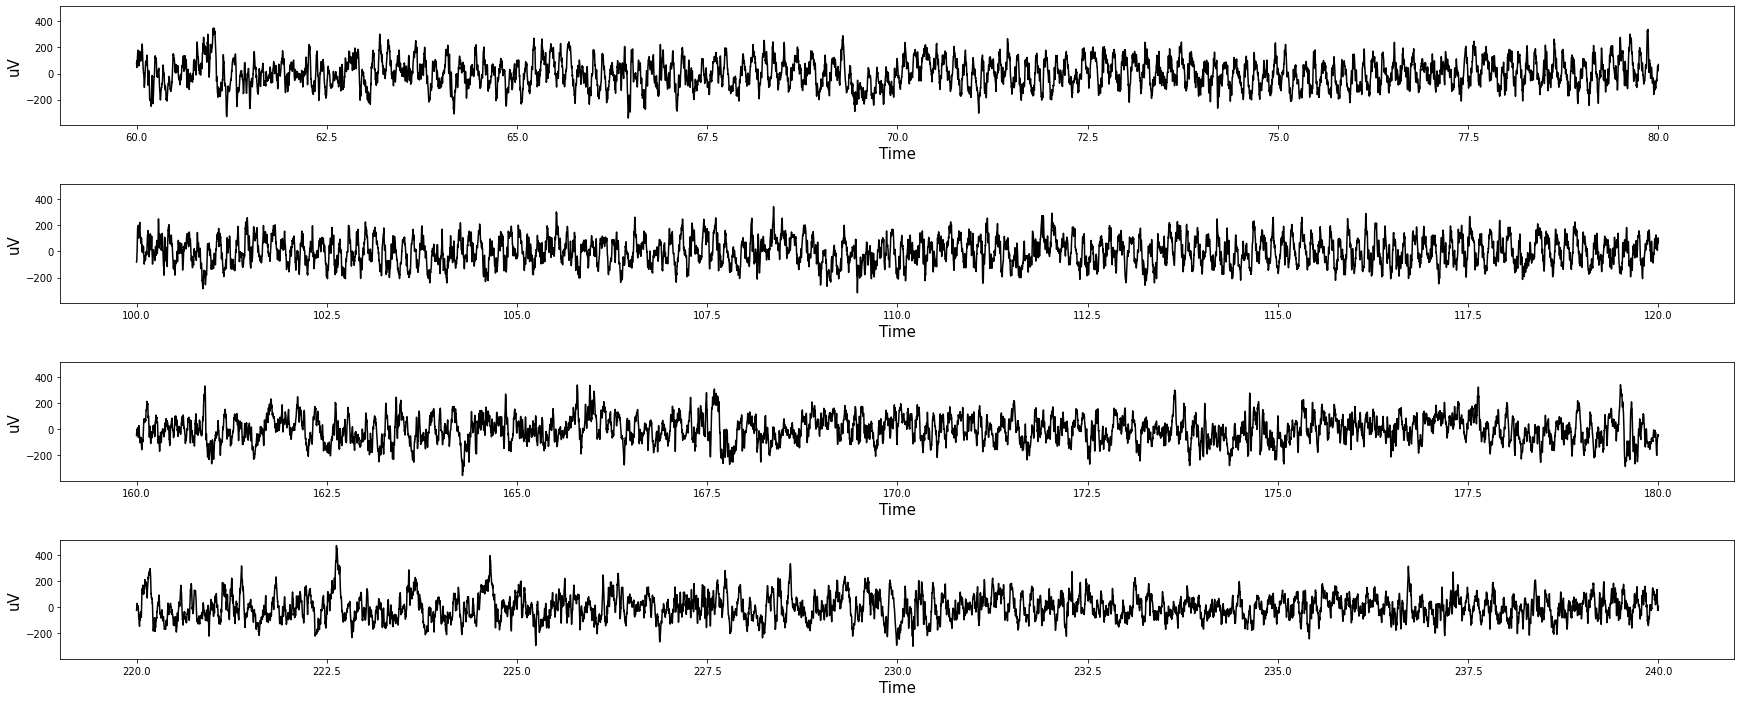

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(30, 12), facecolor='w', edgecolor='k', sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.3)

axs = axs.ravel()

axs[0].plot(subset[0][0],subset[0][1], color = 'k')
axs[0].set_xlabel('Time', fontsize = 15)
axs[0].set_ylabel('uV', fontsize = 15)
axs[1].plot(subset[1][0],subset[1][1], color = 'k')
axs[1].set_xlabel('Time', fontsize = 15)
axs[1].set_ylabel('uV', fontsize = 15)
axs[2].plot(subset[2][0],subset[2][1], color = 'k')
axs[2].set_xlabel('Time', fontsize = 15)
axs[2].set_ylabel('uV', fontsize = 15)
axs[3].plot(subset[3][0],subset[3][1], color = 'k')
axs[3].set_xlabel('Time', fontsize = 15)
axs[3].set_ylabel('uV', fontsize = 15)

PSD

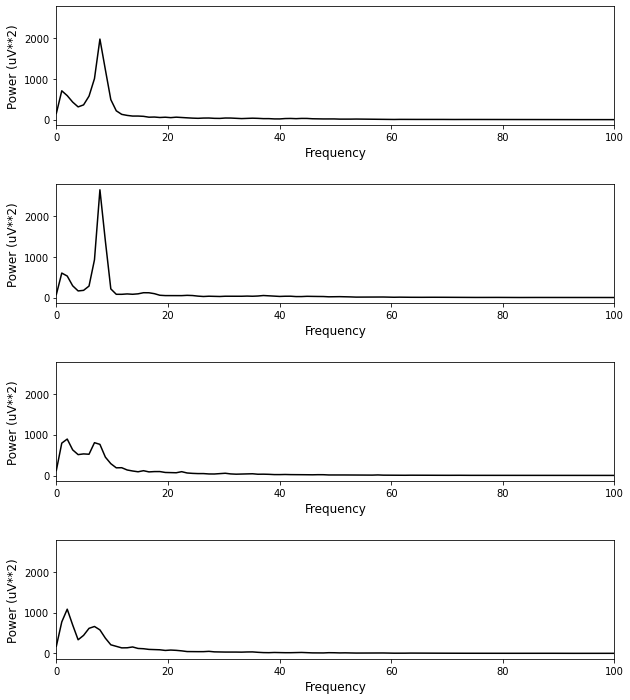

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(10, 12), facecolor='w', edgecolor='k', sharey = True)
fig.subplots_adjust(hspace = .5, wspace=.3)

axs = axs.ravel()

for i in range(4):
    f, Pxx_den = signal.welch(subset[i][1], 1000, nperseg=1024)
    axs[i].plot(f, Pxx_den, color = 'k')
    axs[i].set_xlim(0,100)
    axs[i].set_xlabel('Frequency', fontsize = 12)
    axs[i].set_ylabel('Power (uV**2)', fontsize = 12)

Spectogram

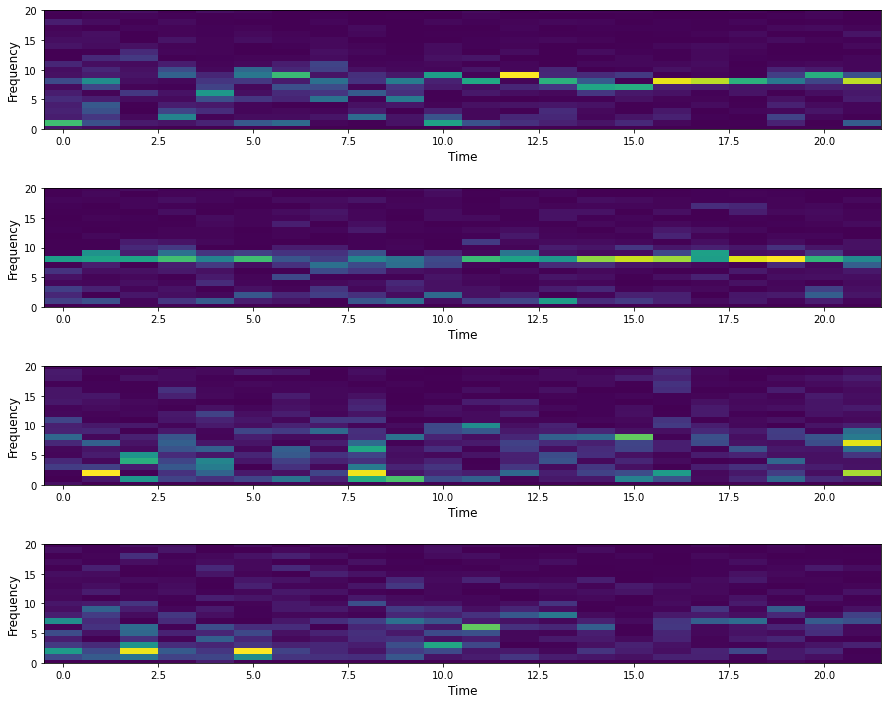

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(15, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)

axs = axs.ravel()

for i in range(4):
    freq, times, spec = signal.spectrogram(subset[i][1], 1000,nperseg=1024)

    axs[i].imshow(spec,aspect='auto', cmap = 'viridis')
    fig.gca().invert_yaxis()
    axs[i].set_ylim(0,20)
    axs[i].set_xlabel('Time', fontsize = 12)
    axs[i].set_ylabel('Frequency', fontsize = 12)

## Spikes example <a name="spikes"></a>

Load data

In [2]:
data = loadmat('/content/PyRAT_dataset/spikes_data.mat')
whlrl = data['whlrld']
spiket = data['spiket']
spikeind = data['spikeind']

In [3]:
#@title Preprocessing the spike data we want to visualize. This step will be specific for each data that you want to use.
def preprocess_spikes(videofs, spikefs, whlrl, spiket, spikeind):
    '''
        Pre-process the data to create the input for the function heatmap_spikes

        Input:
            videofs (float) :  video sampling rate
            spikefs (float) : spike time sampling rate
            whlrl (ndarray): tracking data with 2 columns per N rows where N is
                            the number of frames, first column is the tracking x
                            from any rat body part, and second column is the y.
            spiket (ndarray): spike times of each unit
            spkeind (ndarray): unit index of each spike time

        Returns:
            df_disparos (dataframe): a dataframe with columns: x, y, unit_1, unit_2... unit_n
                                    where each column unit_n count the number of spikes for unit_n
                                    for each frame.
    '''
    fs = videofs

    df = pd.DataFrame(data=whlrl[:, 0:2], columns=['x', 'y'])

    disparos_unit = {}
    disparos_pos = {}
    disparos_pos['x'] = []
    disparos_pos['y'] = []

    for unit in pd.DataFrame(spikeind)[0].value_counts().index.values:
        disparos_unit[unit] = []

    for x in range(whlrl.shape[0]-1):
        start = x*1/fs
        end = start + 1/fs
        indices_dispararam = np.where( (spiket >= start*spikefs) & (spiket < end*spikefs) )
        disparos_pos['x'].append( whlrl[x,0] )
        disparos_pos['y'].append( whlrl[x, 1] )
        for unit in disparos_unit.keys():
            ndisparos = ( spikeind[indices_dispararam[0]] == unit).sum()
            disparos_unit[unit].append(ndisparos) 

    df_disparos = pd.DataFrame.from_dict(disparos_unit)
    df_disparos['x'] = disparos_pos['x']
    df_disparos['y'] = disparos_pos['y']
    return df_disparos

whlrl = whlrl[whlrl[:, 6] != 0, : ]
whlrl = whlrl[whlrl[:, 6] != 1, : ]
spikes = preprocess_spikes(39.0625, 20000, whlrl, spiket, spikeind)


In [4]:
#@title Example of SpacialNeuralActivity() function input data. A dataframe must be passed with the neural data and the tracking data in columns. 
spikes.head()

,62.0,32.0,55.0,51.0,42.0,50.0,41.0,33.0,63.0,34.0,46.0,12.0,54.0,61.0,35.0,59.0,38.0,27.0,22.0,49.0,53.0,6.0,18.0,13.0,52.0,56.0,19.0,30.0,20.0,47.0,17.0,23.0,43.0,36.0,2.0,40.0,37.0,39.0,8.0,29.0,48.0,25.0,28.0,58.0,44.0,16.0,9.0,4.0,14.0,26.0,21.0,45.0,15.0,57.0,1.0,11.0,24.0,31.0,7.0,10.0,5.0,3.0,60.0,x,y
0,1,0,2,2,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,588.9894,270.3096
1,1,0,0,0,3,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,586.0000,272.5301
2,1,1,1,1,1,1,0,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,598.0000,255.3100
3,0,3,0,3,3,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,598.4588,255.4588
4,3,0,0,2,2,2,0,1,2,1,2,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,599.2276,256.0000


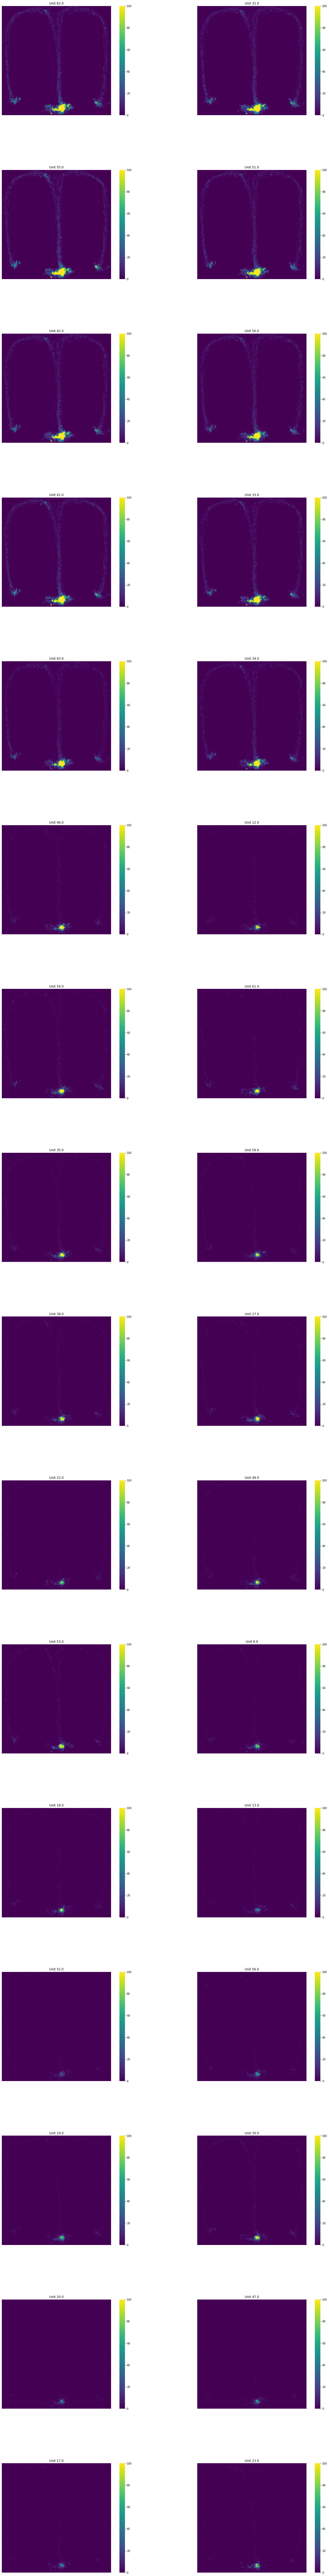

In [5]:
fig, axs = plt.subplots(16,2, figsize=(25, 180), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.15)
axs = axs.ravel()

for i in range(32):
    h = rat.SpacialNeuralActivity(spikes, spikes.columns[i])
    sns.heatmap(h, cmap='viridis', vmax=100, ax =axs[i], square=True)
    axs[i].set_title('Unit ' + str(spikes.columns[i]))
    axs[i].set_xticks([])
    axs[i].set_yticks([])